# Plotting results of predictions

Here, the outputs from `5_combine_ensembles.ipynb` are plotted. There are various types of plots, some that are used in the manuscript and some that are not


pip install odc-geo==0.4.0rc1

In [ ]:
import folium
import odc.geo
import numpy as np
import xarray as xr
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject
from datacube.utils.cog import write_cog
from matplotlib.colors import ListedColormap

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import allNaN_arg

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

## Analysis Parameters

In [ ]:
var = 'ET'
suffix='20230320'
# results_name = var+'_2003_2022_1km_quantiles_'+suffix+'.nc'
# results_name = var+'_2003_2022_1km_quantiles.nc'
results_name ='AusEFlux_'+var+'_2003_2022_1km_quantiles_v1.1.nc'
# mask_path = '/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/mask_5km.nc'

# upper = var+'_2003_2021_5km_LGBM_quantiles_'+suffix+'.nc'

### Open predictions

In [ ]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name,
                      chunks = dict(x=1100,y=1100, time=1)
                      )
ds = assign_crs(ds, crs='EPSG:4326')
ds

## Convert to PgC/year

In [ ]:
grid = ds.odc.geobox.to_crs('EPSG:3577')

In [ ]:
ds = ds.odc.reproject(how=grid, resampling='bilinear')

In [ ]:
%%time
ds = ds.compute()
# ds = ds.sel(quantile=0.5).compute()

In [ ]:
area_per_pixel

In [ ]:
ds.geobox.resolution[1]

In [ ]:
area_per_pixel = ds.geobox.resolution[1]**2

if var != 'ET':
    ds = ds * area_per_pixel * 1e-15 * 12 # (pgC/year)
else:
    ds = ds * 12 # (mm/year)

## Fire emissions

In [ ]:
fire = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/FireEmissions_10km_monthly_2003_2022.nc')
fire = fire.sum(['x', 'y'])
fire = fire*12


## Interannual variability and annual mean

In [ ]:
annual_ds = ds.sel(time=slice('2003', '2021')).resample(time='1Y').sum()
annual_fire = fire.sel(time=slice('2003', '2021')).resample(time='1Y').sum()

In [ ]:
upper_percentile = (annual_ds[var+'_75th_percentile'].sum(['x','y']) / 12).mean().values
lower_percentile = (annual_ds[var+'_25th_percentile'].sum(['x','y']) / 12).mean().values
print('This Study Annual Mean (median model): ',(annual_ds[var+'_median'].sum(['x','y']) / 12).mean().values)
print('This Study Annual Mean (median model)+FIRE: ', ((annual_ds[var+'_median'].sum(['x','y'])+annual_fire)/12).mean().values)
print('This Study annual mean 75th percentile: ',upper_percentile)
print('This Study annual mean 25th percentile: ',lower_percentile)
print('IQR = ',upper_percentile-lower_percentile)

In [ ]:
print('This Study IAV (median model): ',(annual_ds[var+'_median'].sum(['x','y']) / 12).std().values)
print('This Study IAV (median model) + FIRE: ',((annual_ds[var+'_median'].sum(['x','y'])+annual_fire)/12).std().values)

In [ ]:
ds_clim_mean = ds[var+'_median'].groupby('time.month').mean()
print('Seasonal range of '+var, ds_clim_mean.sum(['x','y']).max().values - ds_clim_mean.sum(['x','y']).min().values)

if var=='NEE':
    ds_1D = ds[var+'_median'].sum(['x','y'])
    ds_fire_1d = ds_1D+fire
    ds_clim_mean_fire = ds_fire_1d.groupby('time.month').mean()
    print('Seasonal range with fire of '+var, ds_clim_mean_fire.max().values - ds_clim_mean_fire.min().values)

## Anomalies

In [ ]:
# ds_clim_mean = ds.groupby('time.month').mean()
# ds_anom = (ds.groupby('time.month') - ds_clim_mean)

In [ ]:
# ds_1d = ds.sum(['x', 'y'])

# ds_fire_1d = ds_1d+fire
# ds_fire_clim_mean = ds_fire_1d.groupby('time.month').mean()
# ds_fire_anom = (ds_fire_1d.groupby('time.month') - ds_fire_clim_mean)

In [ ]:
# ds_fire_anom.sel(quantile=0.5).rolling(time=12, min_periods=12).mean().plot(figsize=(11,5))

## Zonal timeseries


In [ ]:
# ds_1D = ds.sum(['x','y'])

ds_1D = ds[var+'_median'].rename(var).sum(['x','y'])
upper_1D = ds[var+'_75th_percentile'].sum(['x','y'])
lower_1D = ds[var+'_25th_percentile'].sum(['x','y'])

In [ ]:
df_1d = ds_1D.drop(['spatial_ref']).to_dataframe()
if var == 'NEE':
    df_1d['NEE+fire'] = ds_fire_1d.drop(['spatial_ref'], axis=1).to_dataframe(name='NEE+fire')

fig,ax = plt.subplots(1,2, figsize=(15,5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
ds_1D.plot(linestyle='-', ax=ax[0], label=var)
ds_1D.rolling(time=12, min_periods=12).mean().plot(ax=ax[0], label=var+' 12-month rolling mean')
ax[0].fill_between(ds_1D.time, lower_1D, upper_1D, alpha=0.2)
df_1d.boxplot(ax=ax[1], rot=0, grid=False, fontsize=14, showmeans=True, color={'medians': 'blue'}, meanprops={'markerfacecolor': 'blue', 'markeredgecolor':'blue'})

if var == 'NEE':
    ds_fire_1d.plot(linestyle='--', ax=ax[0], label='NEE+Fire', c='purple', alpha=0.5)
    ds_fire_1d.rolling(time=12, min_periods=12).mean().plot(ax=ax[0], label='NEE+fire 12-month rolling mean')
    ax[0].axhline(0, c='grey', linestyle='--')
    ax[1].axhline(0, c='grey', linestyle='--')

# if var!='NEE':
    # ax[0].set_ylim(1.0, 8.0)
    
if var != 'ET':
    ax[0].set_ylabel(var+' PgC/year', fontsize=14)
else:
    ax[0].set_ylabel(var+' mm/year', fontsize=14)
ax[0].xaxis.set_major_locator(mdates.YearLocator(2))
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)
ax[0].set_yticklabels(['{:3.1f}'.format(x) for x in ax[0].get_yticks()])
ax[0].set_xlabel('')
ax[0].set_title('')
ax[0].grid('off', which='major', axis='both', linestyle='--', linewidth=0.75)
ax[1].grid('off', which='major', axis='y', linestyle='--', linewidth=0.75)
ax[0].legend(loc='best', fontsize=14)
plt.tight_layout()
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_aus_timeseries_with_boxplot_'+suffix+'.png')

## Plots per bioregion

In [ ]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')
gdf.head()

In [ ]:
# Dictionary to save results 
results = {}
for index, row in gdf.iterrows():
    print(row['region_name'])

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    dss = ds.where(mask)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({row['region_name']: dss})

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(15,10), sharex=True)

for ax, k in zip(axs.ravel(), results.keys()):
    
    _1D = results[k].sel(quantile=0.5).sum(['x','y'])
    
    _1D.plot(linestyle='--', ax=ax, label=var, )
    ax.text(.015, .95, f'Mean: {_1D.mean().values:.3f}, std: {_1D.std().values:.3f} PgC/yr',
        transform=ax.transAxes, fontdict={'fontsize': 14})
    if var=='NEE':
        ax.axhline(0, c='grey', linestyle='--')
    ax.set_title(k, fontdict={'fontsize': 14})
    ax.set_ylabel('')
    ax.set_xlabel('')

fig.supylabel(var+' PgC/year', fontsize=14)
plt.tight_layout()
# plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_bioregion'+suffix+'.png')

## Per-pixel summaries

In [ ]:
annual_mean = ds.sel(time=slice('2003', '2021'))[var+'_median'].resample(time='1Y').sum().mean('time')
annual_std = ds.sel(time=slice('2003', '2021'))[var+'_median'].resample(time='1Y').sum().std('time')

scaled_variance = annual_std / annual_mean

In [ ]:
monthly_mean = ds[var+'_median'].groupby('time.month').mean() #.sel(time=slice('2003','2015'))

if var == 'NEE':
    max_mean_month = allNaN_arg(monthly_mean.where(monthly_mean!=0), 'month', 'min')
    # max_mean_season = allNaN_arg(monthly_season, 'season', 'min')
else:
    max_mean_month = allNaN_arg(monthly_mean.where(monthly_mean!=0), 'month', 'max')
    # max_mean_season = allNaN_arg(monthly_season, 'season', 'max')

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(18,7), sharey=True)
font=20
vmax = 0.000025
vmin = 0
vmax_sd_nee=0.0000015
vmin_sd_nee=0
vmax_sd=0.00000275
vmin_sd=0.0000

if var == 'NEE':
    im = annual_mean.rename(var+' PgC/year').where(annual_mean!=0).plot.imshow(ax=ax[0], cmap='RdBu_r', vmax=3e-6, vmin=-3e-6, add_colorbar=False, add_labels=False)
    cbar = plt.colorbar(im, location='bottom', pad=0.025, ax=ax[0])
    cbar.set_label(label=var+' PgC/year', size=15, weight='bold')
    cbar.ax.tick_params(labelsize=15)
    cbar.formatter.set_powerlimits((0, 0))
else:
    im = annual_mean.rename(var+' PgC/year').where(annual_mean!=0).plot.imshow(ax=ax[0], cmap='viridis', vmax=vmax, vmin=vmin, add_colorbar=False, add_labels=False)
    cbar = plt.colorbar(im, location='bottom', pad=0.025, ax=ax[0])
    cbar.set_label(label=var+' PgC/year', size=15, weight='bold')
    cbar.ax.tick_params(labelsize=15)

if var=='NEE':
    im1 = annual_std.rename('').where(annual_mean!=0).plot.imshow(ax=ax[1], cmap='magma',vmax=vmax_sd_nee,vmin=vmin_sd_nee, add_colorbar=False, add_labels=False)
else:
    im1 = annual_std.rename('').where(annual_mean!=0).plot.imshow(ax=ax[1], cmap='magma',vmax=vmax_sd,vmin=vmin_sd, add_colorbar=False, add_labels=False)

cbar1 = plt.colorbar(im1, location='bottom', pad=0.025, ax=ax[1])
cbar1.set_label(label=var+' Std. Dev.', size=15, weight='bold')
cbar1.ax.tick_params(labelsize=15)

im2 = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[2], cmap='twilight', add_colorbar=False, add_labels=False)
cbar2 = plt.colorbar(im2, spacing='uniform', ax=ax[2], location='bottom', pad=0.025)
cbar2.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
cbar2.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=15)
cbar2.set_label(label=var+' Month of Max.', size=15, weight='bold')


ax[0].set_yticklabels([])
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_xticklabels([])

ax[0].set_title('Annual Mean of '+var,fontsize=font)
ax[1].set_title('Annual Std.Dev. in '+var, fontsize=font)

if var=='NEE':
    ax[2].set_title('Month of Maximum Carbon Uptake', fontsize=font);
else:
    ax[2].set_title('Month of Maximum '+var, fontsize=font);
    
plt.tight_layout();
# plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_perpixel_summaries_'+suffix+'.png')

In [ ]:
y = monthly_mean.sum(['x','y']).values
x = monthly_mean.month.values
# std = monthly_std.mean(['x','y']).values

fig,ax = plt.subplots(1,1, figsize=(7,4))
ax.plot(x, y, marker='o', linestyle='--')
if var=='NEE':
    ax.axhline(0, c='grey')
# ax.fill_between(x, y-std, y+std, alpha=0.5)
ax.set_title('Monthly Mean '+var+' averaged over Australia')
ax.set_xticks(range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]) 
ax.set_xlabel('Month');
ax.set_ylabel('PgC/year');


## Per bioregion climatology

In [ ]:
# Dictionary to save results 
results = {}
for index, row in gdf.iterrows():
    print(row['region_name'])

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    dss = monthly_mean.where(mask)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({row['region_name']: dss})

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(12,15), sharex=True)

for ax, k in zip(axs.ravel(), results.keys()):
    
    _1D = results[k].sum(['x','y'])
    
    _1D.plot(linestyle='--', ax=ax, label=var, )
    ax.text(.015, .05, f'Mean: {_1D.mean().values:.3f}, std: {_1D.std().values:.3f} PgC/yr',
        transform=ax.transAxes, fontdict={'fontsize': 14})
    if var=='NEE':
        ax.axhline(0, c='grey', linestyle='--')
    ax.set_title(k, fontdict={'fontsize': 14})
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]) 
fig.supylabel(var+' PgC/year', fontsize=14)
plt.tight_layout()
# plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_bioregion_climatology_'+suffix+'.png')

## Interactive map

In [ ]:
# annual_ds = ds.sel(quantile=0.5).resample(time='1Y').sum()
# annual_mean = annual_ds.mean('time')
# annual_std = annual_ds.std('time')

In [ ]:
# Create folium Map (ipyleaflet is also supported)
m = folium.Map(control_scale = True)

# Plot each sample image with different colormap
# max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0], cmap='twilight', add_colorbar=False)
# np.absolute(scaled_variance).where(~mask).odc.add_to(m, opacity=1.0, cmap='magma', vmax=2)
# max_mean_month.odc.add_to(m, opacity=1.0, cmap='twilight', vmin=1, vmax=12)
# annual_std.where(annual_std>0).odc.add_to(m,  cmap='magma', robust=True, opacity=1.0) #opacity=1.0,
annual_mean.where(annual_mean!=0).odc.add_to(m, cmap='RdBu_r', vmin=-300, vmax=300)


# Zoom map to Australia
m.fit_bounds(annual_mean.odc.map_bounds())

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
       ).add_to(m)

folium.LayerControl().add_to(m)
display(m)

## Zoomed in maps

In [ ]:
# #queensland
# x_slice=slice(2700,4200)
# y_slice=slice(850,1800)
# name='queensland'

#SW WA
# x_slice=slice(290,900)
# y_slice=slice(2150,2510)
# name='westernaus'

#Cape York
# x_slice=slice(2600,3600)
# y_slice=slice(20,850)
# name='capeyork'

# # melbourne
# x_slice=slice(2600,3800)
# y_slice=slice(2400,2900)
# name='melbourne'

# NW WA
x_slice=slice(900,2000)
y_slice=slice(300,1000)
name='NW_WA'

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(21,7), sharey=True) # figsize=(21,6),
font=20

if var == 'NEE':
    im = annual_mean.isel(x=x_slice,
                          y=y_slice).rename(var+' gC m\N{SUPERSCRIPT TWO} y⁻¹').where(annual_mean!=0).plot.imshow(ax=ax[0],
                                                                                                                 cmap='RdBu_r',
                                                                                                                 # robust=True,
                                                                                                                  vmin=-250, vmax=250,
                                                                                                                 add_colorbar=False,
                                                                                                                 add_labels=False)
    cbar = plt.colorbar(im, location='bottom', pad=0.05, ax=ax[0])
    cbar.set_label(label=var+' gC m\N{SUPERSCRIPT TWO} year⁻¹', size=15, weight='bold')
    cbar.ax.tick_params(labelsize=15)
    # cbar.formatter.set_powerlimits((0, 0))
else:
    im = annual_mean.isel(x=x_slice, y=y_slice).rename(var+' gC m\N{SUPERSCRIPT TWO} y⁻¹').where(annual_mean!=0).plot.imshow(ax=ax[0], cmap='viridis', robust=True, add_colorbar=False, add_labels=False)
    cbar = plt.colorbar(im, location='bottom', pad=0.05, ax=ax[0])
    cbar.set_label(label=var+' gC m\N{SUPERSCRIPT TWO} y⁻¹', size=15, weight='bold')
    cbar.ax.tick_params(labelsize=15)

im2 = annual_mean.isel(x=x_slice, y=y_slice).where(annual_mean!=0).plot.imshow(ax=ax[2], cmap='viridis', robust=True, add_colorbar=False, add_labels=False)
ctx.add_basemap(ax[2], source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='Esri World Imagery', attribution_size=15)

ax[2].set_aspect('auto')
if var=='NEE':
    im1 = annual_std.isel(x=x_slice, y=y_slice).rename('').where(annual_mean!=0).plot.imshow(ax=ax[1],
                                                                                             cmap='magma',
                                                                                             robust=True,
                                                                                             # vmin=0, vmax=160,
                                                                                             add_colorbar=False,
                                                                                             add_labels=False)
else:
    im1 = annual_std.isel(x=x_slice, y=y_slice).rename('').where(annual_mean!=0).plot.imshow(ax=ax[1], cmap='magma',robust=True, add_colorbar=False, add_labels=False)

cbar1 = plt.colorbar(im1, location='bottom', pad=0.05, ax=ax[1])
cbar1.set_label(label=var+' Std. Dev.', size=15, weight='bold')
cbar1.ax.tick_params(labelsize=15)

cbar2 = plt.colorbar(im2, spacing='uniform', ax=ax[2], location='bottom', pad=0.05)


ax[0].set_ylabel('')
ax[0].set_xlabel('')
# ax[0].set_yticklabels([])
# ax[0].set_xticklabels([])
# ax[1].set_yticklabels([])
# ax[1].set_xticklabels([])
# ax[2].set_yticklabels([])
# ax[2].set_xticklabels([])

ax[0].set_title('Annual Mean of '+var,fontsize=font)
ax[1].set_title('Std.Dev. in Annual '+var, fontsize=font)

ax[2].set_title('True Colour Image', fontsize=font);
    
plt.tight_layout()
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_zoomedin_perpixel_'+name+'.png')

## Summarizing all climatology fluxes

In [1]:
import sys
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

import warnings
warnings.filterwarnings("ignore")

In [2]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 28,Total memory: 123.34 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38199,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 123.34 GiB
Comm: tcp://127.0.0.1:37651,Total threads: 28
Dashboard: /proxy/42989/status,Memory: 123.34 GiB
Nanny: tcp://127.0.0.1:36803,


### Analysis Parameters

In [3]:
results_name_er ='AusEFlux_ER_2003_2022_1km_quantiles_v1.1.nc'
results_name_gpp ='AusEFlux_GPP_2003_2022_1km_quantiles_v1.1.nc'

### Open datasets

In [4]:
er = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name_er,
                      chunks=dict(latitude=1100, longitude=1100, time=1))['ER_median']
er.attrs['nodata'] = np.nan
er = assign_crs(er, crs='EPSG:4326')

In [5]:
gpp = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name_gpp,
                      chunks=dict(latitude=1100, longitude=1100, time=1))['GPP_median']
gpp.attrs['nodata'] = np.nan
gpp = assign_crs(gpp, crs='EPSG:4326')

In [6]:
fire = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/FireEmissions_10km_monthly_2003_2022.nc')
# fire = fire.sum(['x', 'y'])
fire = fire*12

In [7]:
er = er.odc.reproject(how=er.odc.geobox.to_crs('EPSG:3577'),
                      resampling='bilinear').compute()

gpp = gpp.odc.reproject(how=gpp.odc.geobox.to_crs('EPSG:3577'),
                      resampling='bilinear').compute()


### Convert to total C in (petagrams) rather than gC/m2


In [8]:
er = er * er.geobox.resolution[1]**2 * 1e-15 *12
gpp = gpp * gpp.geobox.resolution[1]**2 * 1e-15 *12


### Climatology

In [9]:
import warnings
warnings.filterwarnings("ignore")

er_clim_mean = er.groupby('time.month').mean()
gpp_clim_mean = gpp.groupby('time.month').mean()
fire_clim_mean = fire.groupby('time.month').mean()

### Per bioregion

In [10]:
bio = assign_crs(xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.nc'), crs='EPSG:4326')
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

In [11]:
def make_mask(xx, index):
    mask = bio.odc.reproject(how=xx.odc.geobox, resampling='nearest')
    mask = mask.astype(int)
    mask['x'] = np.array([round(i,6) for i in mask.x.values])
    mask['y'] = np.array([round(i,6) for i in mask.y.values])
    mask = xr.where(mask==index, 1, 0)
    return mask

def round_coords(ds):
    ds['x'] = np.array([round(i,6) for i in ds.x.values])
    ds['y'] = np.array([round(i,6) for i in ds.y.values])
    return ds

In [12]:
# Dictionary to save results 
er_results = {}
for index, row in gdf.iterrows():
    index=index+1
    print(row['region_name'])
    datasets = {}
    
    ds_mask = make_mask(er, index)
    
    dss = round_coords(er_clim_mean).where(ds_mask)
        
    datasets.update({
                'This Study ER':dss,
                }
               )
    # Append results to a dictionary using the attribute
    # column as an key
    er_results.update({row['region_name']: datasets})

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


In [13]:
# Dictionary to save results 
gpp_results = {}
for index, row in gdf.iterrows():
    index=index+1
    print(row['region_name'])
    datasets = {}
    
    ds_mask = make_mask(gpp, index)
    
    dss = round_coords(gpp_clim_mean).where(ds_mask)
        
    datasets.update({
                'This Study GPP':dss,
                }
               )
    # Append results to a dictionary using the attribute
    # column as an key
    gpp_results.update({row['region_name']: datasets})

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


In [14]:
# Dictionary to save results 
fire_results = {}
for index, row in gdf.iterrows():
    index=index+1
    print(row['region_name'])
    datasets = {}
    
    ds_mask = make_mask(fire, index)
    
    dss = round_coords(fire_clim_mean).where(ds_mask)
        
    datasets.update({
                'GFAS Fire':dss,
                }
               )
    # Append results to a dictionary using the attribute
    # column as an key
    fire_results.update({row['region_name']: datasets})

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


### Plot

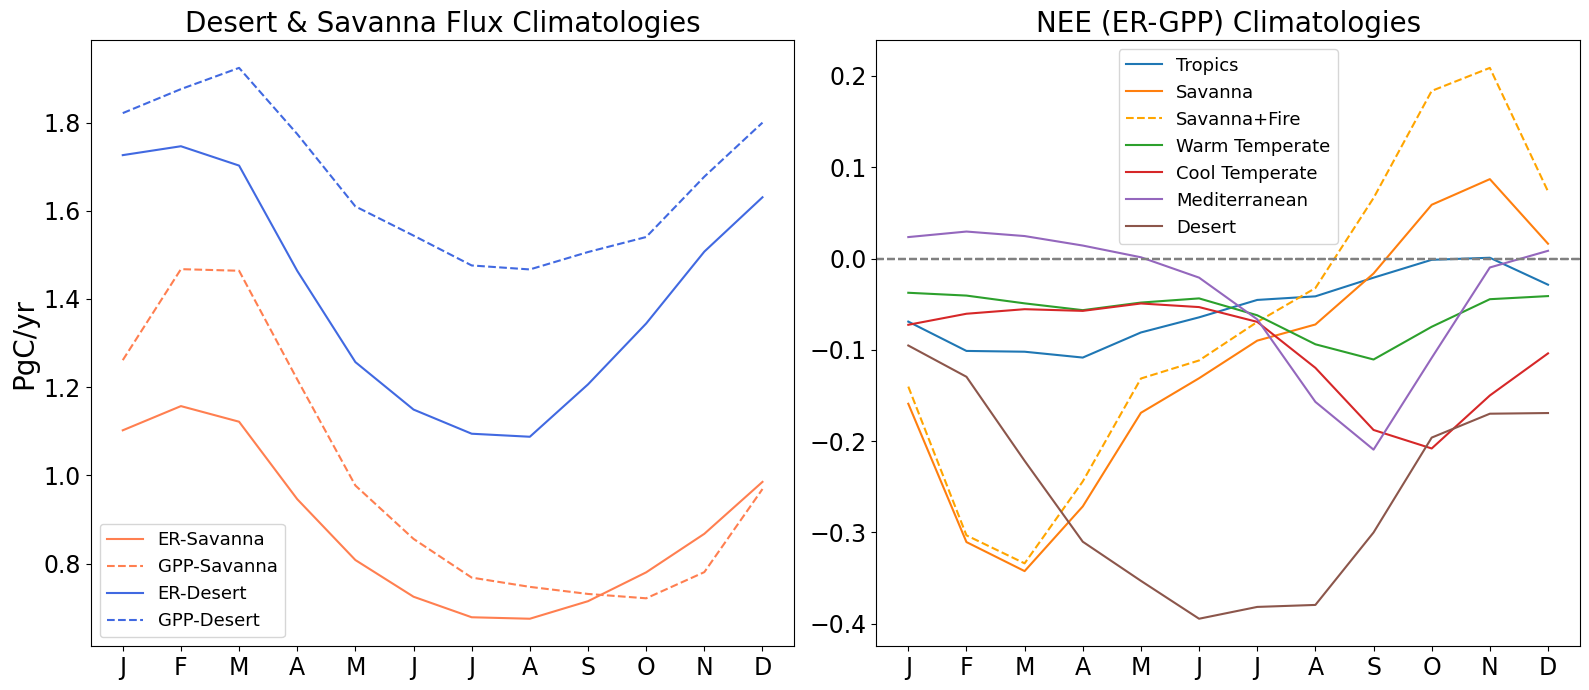

In [20]:
regions = ['Tropics',
'Savanna',
'Warm Temperate',
'Cool Temperate',
'Mediterranean',
'Desert']

fig, ax = plt.subplots(1,2, figsize=(16,7))
for i in regions:
    
    subtract =  er_results[i]['This Study ER'].sum(['x','y']) - gpp_results[i]['This Study GPP'].sum(['x','y'])
    subtract.plot(label=i, ax=ax[1])
    
    if i=='Savanna':
        fire_1d = fire_results[i]['GFAS Fire'].sum(['x','y'])
        (subtract+fire_1d).plot(label=i+'+Fire', ax=ax[1], linestyle='--', color='orange')
    # if i=='Desert':
    #     fire_1d = fire_results[i]['GFAS Fire'].sum(['x','y'])
    #     (subtract+fire_1d).plot(label=i+'+Fire', ax=ax[1], linestyle='--', color='brown')
        
    ax[1].legend(fontsize=13)
    ax[1].set_title('NEE (ER-GPP) Climatologies', fontsize=20)
    ax[1].set_ylabel('')
    ax[1].tick_params(axis='y', labelsize=17)
    ax[1].set_xlabel('')
    ax[1].set_xticks(range(1,13))
    ax[1].set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=17)
    ax[1].axhline(0, c='grey', linestyle='--')
    
er_results['Savanna']['This Study ER'].sum(['x','y']).plot(ax=ax[0], label='ER-Savanna', c='coral')
gpp_results['Savanna']['This Study GPP'].sum(['x','y']).plot(ax=ax[0], label='GPP-Savanna', c='coral', linestyle='--')

er_results['Desert']['This Study ER'].sum(['x','y']).plot(ax=ax[0], label='ER-Desert',c='royalblue' )
gpp_results['Desert']['This Study GPP'].sum(['x','y']).plot(ax=ax[0], label='GPP-Desert',  c='royalblue', linestyle='--')

ax[0].legend(fontsize=13)
ax[0].set_title('Desert & Savanna Flux Climatologies', fontsize=20)
ax[0].set_ylabel('PgC/yr', fontsize=20)
ax[0].tick_params(axis='y', labelsize=17)
ax[0].set_xlabel('')
ax[0].set_xticks(range(1,13))
ax[0].set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=17)
    
plt.tight_layout()

# plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/desert_savanna_climatology.png',
#             bbox_inches='tight');     